In [1]:
import matplotlib.pyplot as plt
import pandas as pd


import numpy as np
from copy import deepcopy
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
class ModelTree(object):

    def __init__(self, model, max_depth=5, min_samples_leaf=10):

        self.model = model
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.tree = None



    # ======================
    # Fit
    # ======================
    def fit(self, X, y, verbose=False):

        # Settings
        model = self.model
        min_samples_leaf = self.min_samples_leaf
        max_depth = self.max_depth



        if verbose:
            print(" max_depth={}, min_samples_leaf={}...".format(max_depth, min_samples_leaf))

        def _build_tree(X, y):

            global index_node_global

            def _create_node(X, y, depth, container):
                loss_node, model_node = _fit_model(X, y, model)
                node = {"name": "node",
                        "index": container["index_node_global"],
                        "loss": loss_node,
                        "model": model_node,
                        "data": (X, y),
                        "n_samples": len(X),
                        "j_feature": None,
                        "threshold": None,
                        "children": {"left": None, "right": None},
                        "depth": depth}
                container["index_node_global"] += 1
                return node

            # Recursively split node + traverse node until a terminal node is reached
            def _split_traverse_node(node, container):

                # Perform split and collect result
                result = _splitter(node, model, max_depth=max_depth,min_samples_leaf=min_samples_leaf)

                # Return terminal node if split is not advised
                if not result["did_split"]:
                    if verbose:
                        depth_spacing_str = " ".join([" "] * node["depth"])
                        print(" {}*leaf {} @ depth {}: loss={:.6f}, N={}".format(depth_spacing_str, node["index"], node["depth"], node["loss"], result["N"]))
                    return

                # Update node information based on splitting result
                node["j_feature"] = result["j_feature"]
                node["threshold"] = result["threshold"]
                del node["data"]  # delete node stored data

                # Extract splitting results
                (X_left, y_left), (X_right, y_right) = result["data"]
                model_left, model_right = result["models"]

                # Report created node to user
                if verbose:
                    depth_spacing_str = " ".join([" "] * node["depth"])
                    print(" {}node {} @ depth {}: loss={:.6f}, j_feature={}, threshold={:.6f}, N=({},{})".format(depth_spacing_str, node["index"], node["depth"], node["loss"], node["j_feature"], node["threshold"], len(X_left), len(X_right)))

                # Create children nodes
                node["children"]["left"] = _create_node(X_left, y_left, node["depth"]+1, container)
                node["children"]["right"] = _create_node(X_right, y_right, node["depth"]+1, container)
                node["children"]["left"]["model"] = model_left
                node["children"]["right"]["model"] = model_right

                # Split nodes
                _split_traverse_node(node["children"]["left"], container)
                _split_traverse_node(node["children"]["right"], container)

            container = {"index_node_global": 0}  # mutatable container
            root = _create_node(X, y, 0, container)  # depth 0 root node
            _split_traverse_node(root, container)  # split and traverse root node

            return root

        # Construct tree
        self.tree = _build_tree(X, y)
        return self.tree

    # ======================
    # Predict
    # ======================
    def predict(self, X):
        assert self.tree is not None
        def _predict(node, x):
            no_children = node["children"]["left"] is None and \
                          node["children"]["right"] is None
            if no_children:
                y_pred_x = node["model"].predict([x])[0]
                return y_pred_x
            else:
                if x[node["j_feature"]] <= node["threshold"]:  # x[j] < threshold
                    return _predict(node["children"]["left"], x)
                else:  # x[j] > threshold
                    return _predict(node["children"]["right"], x)
        y_pred = np.array([_predict(self.tree, x) for x in X])
        return y_pred



    # ======================
    # Loss
    # ======================
    def loss(self, X, y, y_pred):
        loss = self.model.loss(X, y, y_pred)
        return loss






def _splitter(node, model,max_depth=5, min_samples_leaf=10):

    # Extract data
    X, y = node["data"]
    depth = node["depth"]
    N, d = X.shape

    # Find feature splits that might improve loss
    did_split = False
    loss_best = node["loss"]
    data_best = None
    models_best = None
    j_feature_best = None
    threshold_best = None

    # Perform threshold split search only if node has not hit max depth
    if (depth >= 0) and (depth < max_depth):

        for j_feature in range(d):



            threshold_search = []

            for i in range(N):
                threshold_search.append(X[i, j_feature])


            # Perform threshold split search on j_feature
            for threshold in threshold_search:

                # Split data based on threshold
                (X_left, y_left), (X_right, y_right) = _split_data(j_feature, threshold, X, y)
                N_left, N_right = len(X_left), len(X_right)

                # Splitting conditions
                split_conditions = [N_left >= min_samples_leaf,
                                    N_right >= min_samples_leaf]

                # Do not attempt to split if split conditions not satisfied
                if not all(split_conditions):
                    continue

                # Compute weight loss function
                loss_left, model_left = _fit_model(X_left, y_left, model)
                loss_right, model_right = _fit_model(X_right, y_right, model)
                loss_split = (N_left*loss_left + N_right*loss_right) / N

                # Update best parameters if loss is lower
                if loss_split < loss_best:
                    did_split = True
                    loss_best = loss_split
                    models_best = [model_left, model_right]
                    data_best = [(X_left, y_left), (X_right, y_right)]
                    j_feature_best = j_feature
                    threshold_best = threshold

    # Return the best result
    result = {"did_split": did_split,
              "loss": loss_best,
              "models": models_best,
              "data": data_best,
              "j_feature": j_feature_best,
              "threshold": threshold_best,
              "N": N}

    return result

def _fit_model(X, y, model):
    model_copy = deepcopy(model)  # must deepcopy the model!
    model_copy.fit(X,y)
    y_pred = model_copy.predict(X)
    loss = model_copy.loss(X, y, y_pred)
    assert loss >= 0.0
    return loss, model_copy

def _split_data(j_feature, threshold, X, y):
    idx_left = np.where(X[:, j_feature] <= threshold)[0]
    idx_right = np.delete(np.arange(0, len(X)), idx_left)

    assert len(idx_left) + len(idx_right) == len(X)
    return (X[idx_left], y[idx_left]), (X[idx_right], y[idx_right])


In [3]:
class logistic_regr:

    def __init__(self):
        from sklearn.linear_model import LogisticRegression
        self.model = LogisticRegression(penalty="l2",solver='liblinear')
        self.flag = False
        self.flag_y_pred = None

    def fit(self, X, y):
        y_unique = list(set(y))
        if len(y_unique) == 1:
            self.flag = True
            self.flag_y_pred = y_unique[0]
        else:
            self.model.fit(X, y)

    def predict(self, X):
        if self.flag:
            return self.flag_y_pred * np.ones((len(X),), dtype=int)
        else:
            return self.model.predict(X)

    def loss(self, X, y, y_pred):
        return mean_squared_error(y, y_pred)

    def predict_proba(self,X):
        return self.model.predict_proba(X)

In [4]:
#Read dataset
dataset = pd.read_csv('cleveland.csv')
X = dataset.iloc[:,:-1].values
y = dataset.iloc[:, 13].values
print(X)
print(y)

[[63.  1.  1. ...  3.  0.  6.]
 [67.  1.  4. ...  2.  3.  3.]
 [67.  1.  4. ...  2.  2.  7.]
 ...
 [68.  1.  4. ...  2.  2.  7.]
 [57.  1.  4. ...  2.  1.  7.]
 [57.  0.  2. ...  2.  1.  3.]]
[0 1 1 0 0 0 1 0 1 1 0 0 1 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 0 1 0 1 1 0 0 0 1
 1 1 0 1 0 0 0 1 1 0 1 0 0 0 0 1 0 1 1 1 1 0 0 1 0 1 0 1 1 1 0 1 1 0 1 1 1
 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 1 0 1 1 1 1 1 1
 0 1 1 0 0 0 1 1 1 1 0 1 1 0 1 1 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 1 0 1 1 0 0
 0 0 0 0 1 1 1 1 1 1 0 0 1 0 0 0 0 0 1 0 1 0 1 0 1 1 0 1 0 0 1 1 0 0 1 0 0
 1 1 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 1 1 1 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 1 1
 0 0 0 1 1 0 1 1 0 0 1 1 1 0 0 0 0 0 1 0 1 1 1 1 0 0 1 0 0 0 0 0 0 0 1 0 1
 0 0 1 1 1 1 0 1 0 1 0 1 0 0 0 1 0 1 0 1 0 1 1 1 0 0 1 0 1 1 1 0 1 1 1 1 1
 1]


In [5]:


# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state =100001)
X_test.shape

(45, 13)

In [6]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [7]:
#No of decisioin Trees
esitmators=50
y_pred=[]
n_train_split=int(len(X_train)/esitmators)
inital_train=0
final_train=0


yy_pred=[]
classifier=None

for i in range(1,esitmators+1):

    classifier =logistic_regr()

    final_train=i*n_train_split
    temp_X_train=X_train[inital_train:final_train]
    temp_y_train=y_train[inital_train:final_train]


    L=ModelTree(classifier,max_depth=20, min_samples_leaf=10)

    node=L.fit(temp_X_train,temp_y_train,verbose=False)
    classifier=node["model"]

    y_pred_temp=L.predict(X_test)
    yy_pred.append(y_pred_temp)

for j in range(len(yy_pred[0])):
    curr=[]
    for i in range(len(yy_pred)):
        curr.append(yy_pred[i][j])
    a=curr.count(0)
    b=curr.count(1)
    if a>b:
        y_pred.append(0)
    else:
        y_pred.append(1)



In [8]:
#ACCURACY SCORE
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.8

In [9]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[17,  3],
       [ 6, 19]], dtype=int64)

In [10]:
#Interpretation:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.85      0.79        20
           1       0.86      0.76      0.81        25

    accuracy                           0.80        45
   macro avg       0.80      0.80      0.80        45
weighted avg       0.81      0.80      0.80        45



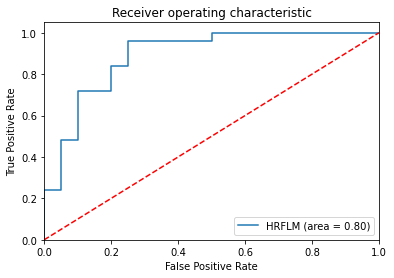

In [11]:

#ROC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='HRFLM (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()